# OT_Coupling1：ミニバッチ内 Optimal Transport（Hungarian）coupling を用いた Flow Matching（two-moons）

## 概要
- 目的：ミニバッチ内で OT coupling を作り，マッチングの“対応付け”を明示的に改善するアイデアを最小例で確認します．
- 内容：two-moons データを用い，Hungarian（linear_sum_assignment）での coupling と学習挙動を可視化します．
- 実行：上から順に実行（Run All）してください（学習ループあり）．
- 依存：torch, numpy, scipy, scikit-learn, matplotlib（GPU は任意）．
- 出力：coupling の図示，生成サンプルの推移．

## 実行メモ
- 乱数性があります（seed を固定したい場合は冒頭セルで設定してください）．
- 実行環境：Python 3 系（推奨：3.10+）．GPU は任意です．


Training Independent Coupling...
[independent] Step 0, Loss: 1.6883
[independent] Step 1000, Loss: 0.9875
[independent] Step 2000, Loss: 1.0357
[independent] Step 3000, Loss: 1.0496
[independent] Step 4000, Loss: 0.9934

Training OT Coupling...
[ot] Step 0, Loss: 0.4549
[ot] Step 1000, Loss: 0.0273
[ot] Step 2000, Loss: 0.0150
[ot] Step 3000, Loss: 0.0198
[ot] Step 4000, Loss: 0.0172


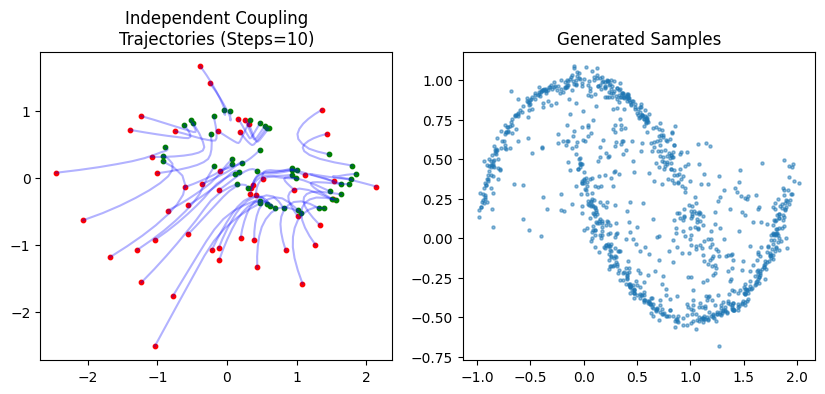

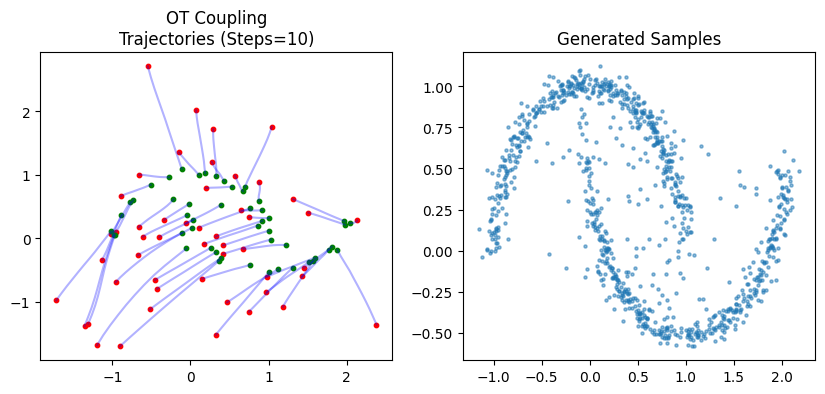

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import make_moons

# 1. ネットワークの定義 (時間依存ベクトル場 v_theta(t, x))
class VelocityField(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 1, hidden_dim), # x(2dim) + t(1dim)
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, t, x):
        # t はスカラーまたは (N, 1)
        if t.dim() == 0:
            t = t.expand(x.shape[0], 1)
        elif t.dim() == 1:
            t = t.unsqueeze(-1)
        tx = torch.cat([t, x], dim=-1)
        return self.net(tx)

# 2. ミニバッチ内 OT Coupling 関数
def get_ot_coupling(x0, x1):
    # x0, x1: (N, 2)
    dist = torch.cdist(x0, x1) # 距離行列
    # 線形割当問題を解く (Kuhn-Munkres法 / Hungarian法)
    row_ind, col_ind = linear_sum_assignment(dist.cpu().detach().numpy() ** 2)
    return x1[col_ind]

# 3. 学習用関数
def train_flow_matching(coupling_type='independent', steps=5000):
    device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
    model = VelocityField().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for i in range(steps):
        optimizer.zero_grad()

        # ターゲットデータ (Moons)
        x1, _ = make_moons(n_samples=256, noise=0.05)
        x1 = torch.tensor(x1, dtype=torch.float32).to(device)

        # ソースノイズ (Standard Normal)
        x0 = torch.randn_like(x1).to(device)

        # カップリングの適用
        if coupling_type == 'ot':
            x1 = get_ot_coupling(x0, x1) # x0に対応するようにx1を並び替え

        # 時間 t ~ Unif[0, 1] [cite: 76]
        t = torch.rand(x1.shape[0], 1).to(device)

        # 条件付き確率パス (線形補間) [cite: 73]
        # x_t = (1-t)x0 + t*x1
        xt = (1 - t) * x0 + t * x1
        ut = x1 - x0 # ターゲット速度 (線形の場合 v = dx/dt = x1 - x0) [cite: 75]

        # 損失関数 (Conditional Flow Matching Objective) [cite: 76]
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f"[{coupling_type}] Step {i}, Loss: {loss.item():.4f}")

    return model

# 4. サンプリング (ODEソルバー: 前進オイラー法) [cite: 81, 87]
@torch.no_grad()
def sample_ode(model, n_steps=10, n_samples=1000):
    device = next(model.parameters()).device
    x = torch.randn(n_samples, 2).to(device)
    dt = 1.0 / n_steps

    traj = [x.cpu().numpy()]
    for i in range(n_steps):
        t = torch.ones(n_samples, 1).to(device) * (i * dt)
        v = model(t, x)
        x = x + v * dt # Euler step [cite: 81]
        traj.append(x.cpu().numpy())

    return x.cpu().numpy(), np.array(traj)

# --- 実験実行 ---
print("Training Independent Coupling...")
model_indep = train_flow_matching(coupling_type='independent')

print("\nTraining OT Coupling...")
model_ot = train_flow_matching(coupling_type='ot')

# --- 可視化 ---
def plot_results(model, title, n_steps=10):
    samples, traj = sample_ode(model, n_steps=n_steps)

    plt.figure(figsize=(10, 4))

    # 軌跡のプロット (最初の50サンプル)
    plt.subplot(1, 2, 1)
    for i in range(50):
        plt.plot(traj[:, i, 0], traj[:, i, 1], color='blue', alpha=0.3)
    plt.title(f"{title}\nTrajectories (Steps={n_steps})")
    plt.scatter(traj[0, :50, 0], traj[0, :50, 1], c='red', s=10, label='Source')
    plt.scatter(traj[-1, :50, 0], traj[-1, :50, 1], c='green', s=10, label='Target')

    # 生成結果の散布図
    plt.subplot(1, 2, 2)
    plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
    plt.title("Generated Samples")
    plt.show()

plot_results(model_indep, "Independent Coupling")
plot_results(model_ot, "OT Coupling")

In [2]:
# 可視化関数の最後に保存処理を追加
def save_results(model, filename):
    samples, traj = sample_ode(model, n_steps=10)
    plt.figure(figsize=(5, 4))
    for i in range(50):
        plt.plot(traj[:, i, 0], traj[:, i, 1], color='blue', alpha=0.3)
    plt.scatter(traj[0, :50, 0], traj[0, :50, 1], c='red', s=10)
    plt.scatter(traj[-1, :50, 0], traj[-1, :50, 1], c='green', s=10)
    plt.savefig(filename, bbox_inches='tight', dpi=300) # ここで保存
    plt.close()

save_results(model_indep, 'independent_coupling.png')
save_results(model_ot, 'ot_coupling.png')